# CNN + BiLSTM (Best Performance)

## Imports

In [1]:
import os
import re
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## Configurations

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Emotion mapping
EMO_MAP = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "NEU": 4,
    "SAD": 5
}
NUM_CLASSES = len(EMO_MAP)

# Data location
NPY_DIR = "mel_npy"


Device: cpu


I use this block to ensure reproducibility, configure the computation device and define all global settings required for model training. By fixing random seeds, I make experimental results repeatable, while dynamically selecting the GPU or CPU ensures efficient execution. I also define spectrogram parameters and emotion label mappings that must match the preprocessing stage, providing a consistent and well-organized configuration for training and evaluating the CNN + BiLSTM model on the CREMA-D dataset.

## Collecting all NPY files

In [3]:
npy_paths = sorted([str(p) for p in Path(NPY_DIR).glob("*.npy")])
print("Found NPY files:", len(npy_paths))


Found NPY files: 7431


## Inferring spectrogram shape

In [4]:
example = np.load(npy_paths[0])
if example.ndim == 3:
    _, N_MELS, T_FRAMES = example.shape
else:
    N_MELS, T_FRAMES = example.shape

print("Spectrogram shape:", (1, N_MELS, T_FRAMES))


Spectrogram shape: (1, 128, 188)


I load one example spectrogram to infer the number of mel bands and time frames, ensuring that the model architecture is configured to exactly match the precomputed features.

The spectrogram shape (1, 128, 188) represents a single-channel log-mel spectrogram with 128 frequency bands observed over 188 time steps, giving the model both spectral and temporal information needed for emotion recognition.

## Parsing actor ID and emotion from filename

In [5]:
def parse_actor_and_emotion(filename: str):

    # Actor ID = first number in filename
    actor_match = re.search(r"\d+", filename)
    if actor_match is None:
        raise ValueError(f"No actor ID in {filename}")
    actor_id = actor_match.group(0)

    # Emotion code
    emotion = None
    for emo in EMO_MAP:
        if f"_{emo}_" in filename or filename.startswith(f"{emo}_"):
            emotion = EMO_MAP[emo]
            break

    if emotion is None:
        raise ValueError(f"No emotion code in {filename}")

    return actor_id, emotion


## Actor-independent split

In [4]:
def actor_independent_split(paths, train_ratio=0.7, val_ratio=0.15):
    by_actor = {}

    for p in paths:
        fname = os.path.basename(p)
        actor_id, _ = parse_actor_and_emotion(fname)
        by_actor.setdefault(actor_id, []).append(p)

    actors = list(by_actor.keys())
    random.shuffle(actors)

    n = len(actors)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_actors = set(actors[:n_train])
    val_actors   = set(actors[n_train:n_train+n_val])
    test_actors  = set(actors[n_train+n_val:])

    def collect(actor_set):
        out = []
        for a in actor_set:
            out.extend(by_actor[a])
        return out

    return (
        collect(train_actors),
        collect(val_actors),
        collect(test_actors)
    )


In [7]:
train_paths, val_paths, test_paths = actor_independent_split(npy_paths)
print(len(train_paths), len(val_paths), len(test_paths))


5141 1066 1224


I use an actor-independent splitting strategy to divide the dataset into training, validation and test sets. By grouping samples by speaker and ensuring that no actor appears in more than one split, I prevent speaker leakage and obtain a more realistic evaluation of how well the model generalizes to unseen speakers.

## PyTorch dataset

In [8]:
class MelNPYDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        fname = os.path.basename(path)

        # loading spectrogram
        spec = np.load(path).astype(np.float32)
        if spec.ndim == 2:
            spec = spec[np.newaxis, :, :]

        # parsing label from filename
        _, label = parse_actor_and_emotion(fname)

        x = torch.from_numpy(spec)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


I use this Dataset class to load precomputed mel spectrograms from .npy files and extract emotion labels directly from their filenames. Each sample is returned in channel-first format along with its corresponding class label, enabling efficient training without relying on external metadata

## Dataloaders

In [9]:
BATCH_SIZE = 32

train_loader = DataLoader(
    MelNPYDataset(train_paths),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    MelNPYDataset(val_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    MelNPYDataset(test_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)


This block of code controls how the data is given to the model while it is training and being evaluated. It does not train the model itself. Instead, it decides how many samples are used at a time, in what order they are read and which data is used for training, validation and testing.

### What BATCH_SIZE = 32 means?
Setting the batch size to 32 means that the model processes 32 audio samples at once.
Instead of learning from one spectrogram at a time, the model learns from small groups of samples.

After processing one batch, the model updates its internal weights. Then it moves on to the next batch, until it has seen the entire dataset.

## What is a DataLoader?
A DataLoader is a tool that reads data from the dataset, groups samples into batches, optionally shuffles the order of samples and feeds the marches to the model during training.

### Shuffling

Training data is shuffled to improve learning and generalization, while validation and test data are kept in a fixed order to ensure fair, repeatable evaluation.

## Setting the device

In [10]:
import torch

DEVICE = torch.device("cpu")
print("Using device:", DEVICE)


Using device: cpu


## CNN + BiLSTM model architecture

In [11]:
class CNNBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, T_FRAMES)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            input_size=lstm_in,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        z = self.cnn(x)                 # (B, C, F, T)
        z = z.permute(0, 3, 1, 2)       # (B, T, C, F)
        z = z.flatten(2)                # (B, T, C*F)
        out, _ = self.lstm(z)           # (B, T, 2H)

        # Better than out[:, -1] for emotion:
        out = out.mean(dim=1)           # (B, 2H)

        return self.fc(out)


This model processes log-Mel spectrograms to classify emotions in speech.
The input has shape (B, 1, N_MELS, T_FRAMES), where the spectrogram is treated as a single-channel image.

A CNN feature extractor first learns local time–frequency patterns (e.g. harmonics, syllable onsets) using convolution, ReLU non-linearity, and max-pooling. Pooling is applied more along the frequency axis than time to preserve temporal resolution for sequence modeling.

The CNN output is reshaped into a time sequence, where each time step contains a compact feature vector. A bidirectional LSTM then models how these features evolve over time, capturing prosodic and temporal cues relevant for emotion.

Finally, a fully connected classification head with dropout maps the LSTM representation to emotion logits. The model outputs raw scores for each emotion class, which are optimized using cross-entropy loss during training.

**CNN–BiLSTM Model: Layer-by-Layer Summary**

**Input** - Shape: (B, 1, N_MELS, T_FRAMES)

**Conv2D (1 → 32, kernel 3×3)** - Learns basic local time–frequency patterns such as edges, harmonics, and short transients

**ReLU** - Introduces non-linearity and suppresses weak or irrelevant activations

**MaxPool2D (2×2)** - Reduces both time and frequency resolution while keeping the strongest features.
Improves robustness and reduces computation.

**Conv2D (32 → 64, kernel 3×3)** - Combines low-level features into more complex spectro-temporal patterns, such as groups of harmonics or repeated structures.

**ReLU** - Preserves strong learned features and enables deeper representation learning.

**MaxPool2D (2×1)** - Reduces frequency resolution while preserving time resolution, which is important for temporal modeling later.

**Conv2D (64 → 128, kernel 3×3)** - Extracts high-level abstract features representing complex audio characteristics across multiple frequency bands.

**ReLU** - Keeps only meaningful high-level activations.

**MaxPool2D (2×1)** - Further compresses frequency information while keeping the temporal structure intact.

**BiLSTM** - Models temporal dependencies in both forward and backward directions, capturing how audio patterns evolve over time

***out.mean(dim=1)*** averages LSTM outputs over all time steps, creating a global emotion representation that is more robust and informative than using only the final frame

**Dropout** - Reduces overfitting by randomly disabling neurons during training.


## Defining one full training epoch and one full validation epoch

In [1]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.append(preds)
        all_true.append(y.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


KeyboardInterrupt: 

This version of the training and evaluation code introduces several important improvements compared to the earlier implementation. Training stability is enhanced by adding gradient clipping, which prevents large gradient updates in the LSTM and leads to smoother convergence. Memory and performance are slightly improved by using a more efficient gradient reset and non-blocking device transfers.

The evaluation logic is also refined by collecting predictions over the entire dataset and computing metrics using accuracy_score and macro-averaged F1 score. This provides a more reliable and informative assessment of model performance, especially for multi-class emotion recognition where some emotions are harder to detect than others.

Overall, these changes do not alter the learning objective, but they make training more stable and evaluation more meaningful and consistent for this task.

## Modeling

In [20]:
model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

# scheduler reduces LR when metric plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6
)

# training limits and early stopping settings
# early stopping will be triggered if there are no improvements for 8 epochs
max_epochs = 120
early_patience = 8
best_val = -1.0
wait = 0
best_path = "best_cremad.pt"

for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1 = evaluate(model, val_loader)

    target_metric = val_f1
    scheduler.step(target_metric)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {lr:.2e}")

    if target_metric > best_val + 1e-4:
        best_val = target_metric
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= early_patience:
            print(f"Early stopping. Best val_f1={best_val:.4f}")
            break

# loading best checkpoint
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
best_acc, best_f1 = evaluate(model, val_loader)
print(f"BEST CHECKPOINT | val_acc={best_acc:.4f} | val_macro_f1={best_f1:.4f}")


Epoch 001 | train_loss 1.5970 | val_acc 0.3587 | val_f1 0.3117 | lr 3.00e-04
Epoch 002 | train_loss 1.4722 | val_acc 0.4291 | val_f1 0.3599 | lr 3.00e-04
Epoch 003 | train_loss 1.4321 | val_acc 0.4451 | val_f1 0.4075 | lr 3.00e-04
Epoch 004 | train_loss 1.3891 | val_acc 0.4451 | val_f1 0.4140 | lr 3.00e-04
Epoch 005 | train_loss 1.3581 | val_acc 0.4638 | val_f1 0.4409 | lr 3.00e-04
Epoch 006 | train_loss 1.3101 | val_acc 0.4911 | val_f1 0.4736 | lr 3.00e-04
Epoch 007 | train_loss 1.2908 | val_acc 0.4995 | val_f1 0.4872 | lr 3.00e-04
Epoch 008 | train_loss 1.2468 | val_acc 0.5127 | val_f1 0.5015 | lr 3.00e-04
Epoch 009 | train_loss 1.2142 | val_acc 0.5099 | val_f1 0.5007 | lr 3.00e-04
Epoch 010 | train_loss 1.1779 | val_acc 0.5099 | val_f1 0.5005 | lr 3.00e-04
Epoch 011 | train_loss 1.1516 | val_acc 0.5446 | val_f1 0.5351 | lr 3.00e-04
Epoch 012 | train_loss 1.1129 | val_acc 0.5221 | val_f1 0.5179 | lr 3.00e-04
Epoch 013 | train_loss 1.0917 | val_acc 0.5587 | val_f1 0.5552 | lr 3.00e-04

**CrossEntropyLoss** is used to measure how far the model’s predicted emotion scores are from the true emotion labels in this multi-class classification task. It internally applies a softmax operation and penalizes incorrect or overconfident predictions.

**AdamW** is the optimizer that updates the model’s parameters to minimize the loss. It uses adaptive learning rates for stable and efficient training, while weight_decay adds regularization to reduce overfitting by discouraging large weights.

Together, the loss function defines what the model should optimize and the optimizer defines how the model learns.

This training configuration combines a CNN–BiLSTM model with a stable and well-controlled optimization strategy. The model is trained using cross-entropy loss and the AdamW optimizer, which provides adaptive learning rates while applying weight decay to reduce overfitting.

A learning-rate scheduler is used to automatically reduce the learning rate when validation performance (macro-F1) plateaus, allowing the model to fine-tune its parameters more effectively in later epochs. Early stopping is applied to halt training once no further improvement is observed, preventing unnecessary training and overfitting.

By monitoring macro-F1, saving the best-performing checkpoint, and restoring it after training, this setup ensures that the final model reflects the best generalization achieved during training rather than the final epoch state.

**The model reached best validation accuracy of around 64 percent and best validation macro F1 of also around 64 percent.**

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = get_preds(model, test_loader, DEVICE)

print(classification_report(y_true, y_pred, target_names=[k for k,v in sorted(EMO_MAP.items(), key=lambda x:x[1])]))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ANG       0.71      0.75      0.73       208
         DIS       0.58      0.59      0.59       208
         FEA       0.60      0.52      0.56       207
         HAP       0.70      0.50      0.58       208
         NEU       0.66      0.73      0.69       178
         SAD       0.53      0.67      0.59       208

    accuracy                           0.62      1217
   macro avg       0.63      0.63      0.62      1217
weighted avg       0.63      0.62      0.62      1217

[[156  24   5  15   7   1]
 [ 19 122  10   4  18  35]
 [ 10  14 107  21   8  47]
 [ 30  17  36 104  14   7]
 [  3   6   2   3 130  34]
 [  2  26  17   2  21 140]]


Overall, the model achieves a test accuracy of 62%, which is a reasonable result for a six-class emotion recognition task using speech audio alone. Considering that random guessing would yield an accuracy of approximately 16.7%, the model demonstrates a substantial ability to extract meaningful emotional information from the audio signals. The macro-averaged F1-score of 0.62 further confirms that the model performs consistently across all classes, without being dominated by any single emotion category.

Examining the per-class metrics reveals important insights into the model’s behavior. Anger (ANG) shows strong performance, with high precision (0.71) and recall (0.75), indicating that anger-related acoustic patterns are well captured by the model. Similarly, Neutral (NEU) achieves relatively high recall (0.73), suggesting that neutral speech characteristics are also distinct enough for reliable recognition.

In contrast, emotions such as Disgust (DIS), Fear (FEA), Happiness (HAP), and Sadness (SAD) exhibit lower and more variable performance. Fear, in particular, has a low recall (0.52), meaning that a significant portion of fear-related samples are misclassified. Happiness shows the opposite pattern: relatively high precision (0.70) but low recall (0.50), indicating that the model predicts happiness conservatively and often fails to detect it when present. Sadness demonstrates moderate recall (0.67) but lower precision (0.53), implying some confusion with other negative emotions.

These patterns suggest that the primary source of error is confusion between acoustically similar emotions, especially among negative emotional states such as fear, disgust, and sadness. This is a well-known challenge in speech emotion recognition, as these emotions often share overlapping prosodic and spectral characteristics, including similar pitch ranges, energy distributions, and speaking rates. Even human listeners may struggle to distinguish these emotions reliably based on audio alone.

The similarity between the macro-averaged and weighted-averaged metrics further confirms that the dataset is well balanced and that no class disproportionately influences the overall performance. As a result, techniques designed to address class imbalance, such as class weighting, are unlikely to yield significant improvements.

## Saving the model

In [22]:
FINAL_PATH = "cnn_bilstm_emotion.pt"

# model should already be the best one (or load best_path first)
torch.save(model.state_dict(), FINAL_PATH)
print("Saved weights to:", FINAL_PATH)


Saved weights to: cnn_bilstm_emotion.pt


In [15]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    cohen_kappa_score,
    log_loss,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns


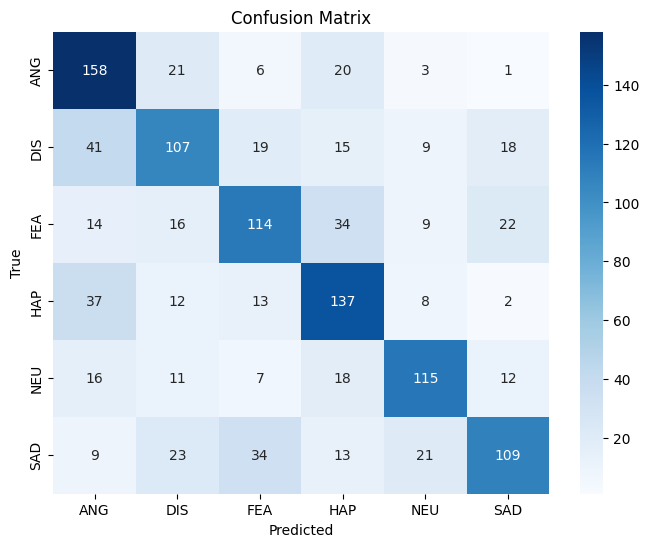

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[k for k, v in sorted(EMO_MAP.items(), key=lambda x: x[1])],
    yticklabels=[k for k, v in sorted(EMO_MAP.items(), key=lambda x: x[1])]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


The confusion matrix shows that the model performs consistently across emotion classes, with strong diagonal values indicating reliable recognition. Most misclassifications occur between acoustically similar emotions, particularly among negative emotional states such as fear, disgust, and sadness. Happiness and anger are also occasionally confused due to shared high-arousal characteristics. These structured error patterns suggest that the model primarily relies on arousal-related acoustic cues, which is typical in speech-based emotion recognition. The results indicate that further improvements are more likely to come from richer temporal modeling or additional emotional descriptors rather than from rebalancing or optimization techniques.

## Comparison of the CNN + BiLSTM models and baseline models

The CNN + BiLSTM model achieves higher accuracy than traditional models such as Random Forests and SVMs because it learns directly from the full spectrogram instead of relying on manually selected features like MFCCs. The CNN automatically detects important patterns in the speech signal, while the BiLSTM models how these patterns change over time. This allows the model to capture emotion-related cues such as changes in pitch, intensity, and rhythm, which classical models cannot represent well.

However, even with these advantages, the CNN + BiLSTM model cannot reach very high accuracy. This is because emotions in speech are not expressed in a consistent or clear way across different speakers. The same emotion can sound very different depending on the person and some emotions have overlapping acoustic characteristics. Additionally, the model is trained only on the available dataset and must learn all representations from scratch, which limits how well it can generalize to unseen speakers.

Overall, the model performs well because it uses deep, time-aware feature learning, but its accuracy is constrained by the complexity of emotion expression and the limitations of audio-only data.

### Impact of the actor-based split

Using an actor-based (speaker-independent) split means that the speakers in the training set do not appear in the validation or test sets. As a result, the model is evaluated on completely unseen voices, which makes the task significantly more difficult but also much more realistic.

Emotion in speech is strongly influenced by speaker-specific traits such as pitch range, speaking style, and intensity. When the model cannot rely on these speaker cues, it must learn general emotion patterns that apply across different people. This greatly reduces the risk of overfitting, but it also limits the maximum achievable accuracy.

Because of this strict split, even deep models like CNN + BiLSTM are unable to reach very high accuracy. However, the results obtained under an actor-based split are more meaningful and better reflect real-world performance, where systems must recognize emotion from speakers they have never heard before.

In summary, the actor-based split lowers accuracy compared to random splits, but it provides a fairer and more reliable evaluation of how well the model truly understands emotion rather than speaker identity.

# WAV LM embeddings

## What are WavLM embeddings?
WavLM embeddings are learned speech representations extracted from a large pretrained self-supervised model that capture rich phonetic and prosodic information from raw audio.

## Configurations

In [1]:
import os, re, random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cpu"

EMO_MAP = {"ANG": 0, "DIS": 1, "FEA": 2, "HAP": 3, "NEU": 4, "SAD": 5}
NUM_CLASSES = len(EMO_MAP)


## Parsing Actor ID and emotion

In [2]:
def parse_actor_and_emotion(filename: str):
    m = re.match(r"^(\d{4})_", filename)
    if m is None:
        raise ValueError(f"Bad CREMA-D filename: {filename}")

    emotion = None
    for emo_code, emo_label in EMO_MAP.items():
        if f"_{emo_code}_" in filename:
            emotion = emo_label
            break
    if emotion is None:
        raise ValueError(f"No emotion code in {filename}")
    return m.group(1), emotion

## Actor-independent split

In [8]:
def actor_independent_split(paths, train_ratio=0.7, val_ratio=0.15, seed=42):
    if train_ratio < 0 or val_ratio < 0 or (train_ratio + val_ratio) > 1.0:
        raise ValueError("train_ratio and val_ratio must be >= 0 and sum to <= 1.0")

    by_actor = {}
    for p in paths:
        fname = os.path.basename(p)
        actor_id, _ = parse_actor_and_emotion(fname)
        by_actor.setdefault(actor_id, []).append(p)

    actors = sorted(by_actor.keys())
    rng = random.Random(seed)
    rng.shuffle(actors)

    n = len(actors)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_actors = set(actors[:n_train])
    val_actors   = set(actors[n_train:n_train + n_val])
    test_actors  = set(actors[n_train + n_val:])

    def collect(actor_set):
        out = []
        for a in actor_set:
            out.extend(by_actor[a])
        return out

    train_paths = collect(train_actors)
    val_paths   = collect(val_actors)
    test_paths  = collect(test_actors)

    return train_paths, val_paths, test_paths, train_actors, val_actors, test_actors


train_paths, val_paths, test_paths, *_ = actor_independent_split(df["file_path"], seed=42)
print(len(train_paths), len(val_paths), len(test_paths))

5141 1066 1224


In [9]:
import pandas as pd

df = pd.read_csv("modelling_metadata.csv")

train_paths, val_paths, test_paths, *_ = actor_independent_split(
    df["file_path"].tolist(),
    train_ratio=0.7,
    val_ratio=0.15,
    seed=SEED
)
print(len(train_paths), len(val_paths), len(test_paths))


5141 1066 1224


## Loading the model and normalizing audio

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, WavLMModel
import numpy as np
import torch
import soundfile as sf
import librosa

MODEL_NAME = "microsoft/wavlm-base"
SAMPLE_RATE = 16000
DEVICE = "cpu"

# Loading WavLM
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
wavlm = WavLMModel.from_pretrained(MODEL_NAME).to(DEVICE)
wavlm.eval()
for p in wavlm.parameters():
    p.requires_grad = False


def load_wav_16k(path: str) -> np.ndarray:
    wav, sr = sf.read(path, always_2d=False)

    # Ensure mono
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)

    if sr != SAMPLE_RATE:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=SAMPLE_RATE)

    # Normalize
    wav = wav / (np.max(np.abs(wav)) + 1e-9)

    return wav.astype(np.float32)


This code loads a pretrained WavLM model as a frozen feature extractor and defines a robust audio preprocessing function that converts any WAV file into normalized, mono, 16 kHz audio suitable for WavLM.

## Function that creates WavLM embeddings

In [ ]:
@torch.no_grad()
def wavlm_embedding(wav_1d: np.ndarray) -> np.ndarray:
    inputs = feature_extractor(
        wav_1d,
        sampling_rate=SAMPLE_RATE,
        return_tensors="pt",
        padding=False
    )
    input_values = inputs["input_values"].to(DEVICE)  # (1, L)

    out = wavlm(input_values=input_values)
    h = out.last_hidden_state  # (1, T, 768)

    mu = h.mean(dim=1)         # (1, 768)
    sigma = h.std(dim=1)       # (1, 768)
    emb = torch.cat([mu, sigma], dim=1)  # (1, 1536)

    return emb.squeeze(0).cpu().numpy().astype(np.float32)


The WavLM model outputs a sequence of frame-level hidden representations, where each frame encodes contextual acoustic information. To convert this variable-length sequence into a fixed-size representation, the function applies statistical pooling over the time dimension. Specifically, it computes the mean and standard deviation of the hidden states across all frames. These two statistics capture both the average characteristics of the signal and its temporal variability.

The mean and standard deviation vectors are then concatenated to form a single embedding of length 1536 (768 dimensions for the mean and 768 for the standard deviation). Gradient computation is disabled to ensure efficient inference, and the final embedding is returned as a NumPy array in float32 format, making it suitable for downstream tasks such as similarity search, clustering, or classification.

## Precomputing the embeddings

In [11]:
import os
import numpy as np

EMB_TRAIN_DIR = "wavlm_emb_train"
EMB_VAL_DIR   = "wavlm_emb_val"
EMB_TEST_DIR  = "wavlm_emb_test"
os.makedirs(EMB_TRAIN_DIR, exist_ok=True)
os.makedirs(EMB_VAL_DIR, exist_ok=True)
os.makedirs(EMB_TEST_DIR, exist_ok=True)

def precompute_embeddings(wav_paths, out_dir, log_every=50):
    saved = 0
    for i, wav_path in enumerate(wav_paths, start=1):
        base = os.path.splitext(os.path.basename(wav_path))[0]
        out_path = os.path.join(out_dir, base + ".npy")

        if os.path.exists(out_path):
            continue

        try:
            w = load_wav_16k(wav_path)
            emb = wavlm_embedding(w)          # (1536,)
            np.save(out_path, emb)
            saved += 1
        except Exception as e:
            print(f"Skip {wav_path}: {e}")
            continue

        if i % log_every == 0:
            print(f"[{out_dir}] {i}/{len(wav_paths)} processed | {saved} saved")

    print(f"Done {out_dir}: saved {saved} embeddings")


In [ ]:
precompute_embeddings(train_paths, EMB_TRAIN_DIR)
precompute_embeddings(val_paths,   EMB_VAL_DIR)
precompute_embeddings(test_paths,  EMB_TEST_DIR)


## Dataset and DataLoader for WavLM embeddings

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch

class EmbDataset(Dataset):
    def __init__(self, wav_paths, emb_dir):
        self.items = []
        for wp in wav_paths:
            base = os.path.splitext(os.path.basename(wp))[0]
            emb_path = os.path.join(emb_dir, base + ".npy")
            _, label = parse_actor_and_emotion(base + ".wav")
            self.items.append((emb_path, label))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        emb_path, label = self.items[idx]
        x = np.load(emb_path).astype(np.float32)   # (1536,)
        return torch.from_numpy(x), torch.tensor(label, dtype=torch.long)

train_loader = DataLoader(EmbDataset(train_paths, EMB_TRAIN_DIR), batch_size=64, shuffle=True)
val_loader   = DataLoader(EmbDataset(val_paths,   EMB_VAL_DIR),   batch_size=128, shuffle=False)
test_loader  = DataLoader(EmbDataset(test_paths,  EMB_TEST_DIR),  batch_size=128, shuffle=False)


This code defines a custom PyTorch dataset and corresponding data loaders for training, validating, and testing a classifier using precomputed WavLM embeddings. Instead of processing raw audio during training, the model operates on fixed-length embedding vectors stored as .npy files, which significantly reduces computational cost and simplifies the training pipeline.

## MLP classifier

In [14]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, classification_report

class MLPClassifier(nn.Module):
    def __init__(self, in_dim=1536, num_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.net(x)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1, y_true, y_pred

model = MLPClassifier(in_dim=1536, num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

best_f1 = -1.0
patience = 8
wait = 0
best_path = "best_wavlm_mlp.pt"

for epoch in range(1, 81):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1, _, _ = evaluate(model, val_loader)
    print(f"Epoch {epoch:03d} | train_loss {tr_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping. Best val_f1={best_f1:.4f}")
            break

model.load_state_dict(torch.load(best_path, map_location=DEVICE))
val_acc, val_f1, y_true, y_pred = evaluate(model, val_loader)
print(f"BEST | val_acc={val_acc:.4f} val_f1={val_f1:.4f}")


Epoch 001 | train_loss 1.6169 | val_acc 0.4568 | val_f1 0.4060
Epoch 002 | train_loss 1.4469 | val_acc 0.4587 | val_f1 0.4343
Epoch 003 | train_loss 1.3654 | val_acc 0.5619 | val_f1 0.5521
Epoch 004 | train_loss 1.3186 | val_acc 0.5901 | val_f1 0.5889
Epoch 005 | train_loss 1.2827 | val_acc 0.6060 | val_f1 0.5983
Epoch 006 | train_loss 1.2629 | val_acc 0.5826 | val_f1 0.5786
Epoch 007 | train_loss 1.2398 | val_acc 0.6041 | val_f1 0.5993
Epoch 008 | train_loss 1.2227 | val_acc 0.6407 | val_f1 0.6401
Epoch 009 | train_loss 1.2101 | val_acc 0.6276 | val_f1 0.6173
Epoch 010 | train_loss 1.1961 | val_acc 0.6360 | val_f1 0.6308
Epoch 011 | train_loss 1.1891 | val_acc 0.6538 | val_f1 0.6539
Epoch 012 | train_loss 1.1818 | val_acc 0.6135 | val_f1 0.6130
Epoch 013 | train_loss 1.1649 | val_acc 0.6398 | val_f1 0.6360
Epoch 014 | train_loss 1.1744 | val_acc 0.6069 | val_f1 0.6043
Epoch 015 | train_loss 1.1742 | val_acc 0.6463 | val_f1 0.6493
Epoch 016 | train_loss 1.1769 | val_acc 0.6604 | val_f1

In this section, I train a lightweight MLP (multi-layer perceptron) classifier on top of the fixed-length WavLM embeddings (1536-dimensional vectors obtained using mean and standard deviation pooling). The objective is to classify each utterance embedding into one of NUM_CLASSES target classes.

I use a simple feed-forward neural network with dropout regularization. The network first applies dropout to the input, then projects the 1536-dimensional embedding to a 256-dimensional hidden layer followed by a ReLU activation. A second dropout layer is applied before the final linear layer produces class logits. For training, I use cross-entropy loss with label smoothing (0.1) to reduce overconfidence and improve generalization. Model parameters are optimized using AdamW, which combines adaptive learning rates with decoupled weight decay.

Training is performed epoch by epoch. During each epoch, I iterate over batches from train_loader, move the data to the selected device, compute logits, evaluate the loss, backpropagate gradients, and update the model parameters. For validation, I switch the model to evaluation mode and compute predictions on val_loader, reporting accuracy and macro-F1. I use macro-F1 as the primary metric because it weights all classes equally and provides a more reliable signal when the class distribution is imbalanced.

To avoid overfitting, I apply early stopping based on validation macro-F1. If the score does not improve for eight consecutive epochs, I stop training. Whenever validation macro-F1 improves, I save the model checkpoint. After training completes, I reload the best-performing checkpoint and report the final validation accuracy and macro-F1 score.

## Saving the model

In [15]:
FINAL_PATH = "wavlm_mlp_emotion_new.pt"

# model should already be the best one (or load best_path first)
torch.save(model.state_dict(), FINAL_PATH)
print("Saved weights to:", FINAL_PATH)


Saved weights to: wavlm_mlp_emotion_new.pt


In [16]:
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.eval()


MLPClassifier(
  (net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1536, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [17]:
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader)

print(f"TEST | acc={test_acc:.4f} | macro_f1={test_f1:.4f}")
print(classification_report(
    y_true, y_pred,
    target_names=["ANG","DIS","FEA","HAP","NEU","SAD"],
    digits=4
))


TEST | acc=0.6209 | macro_f1=0.6201
              precision    recall  f1-score   support

         ANG     0.6968    0.7368    0.7163       209
         DIS     0.5053    0.6890    0.5830       209
         FEA     0.6453    0.6268    0.6359       209
         HAP     0.6150    0.6268    0.6209       209
         NEU     0.8155    0.4693    0.5957       179
         SAD     0.5829    0.5550    0.5686       209

    accuracy                         0.6209      1224
   macro avg     0.6435    0.6173    0.6201      1224
weighted avg     0.6393    0.6209    0.6207      1224



The test-set evaluation demonstrates that the WavLM-based embedding approach achieves stable and balanced performance across all six emotion classes, with an overall accuracy of 62.1% and a macro F1-score of 62.0%. Emotions with distinctive prosodic characteristics, such as anger and fear, are recognized reliably, while more ambiguous categories like disgust and sadness exhibit higher confusion. Neutral speech shows high precision but lower recall, indicating conservative prediction behavior. Overall, the results confirm that pretrained speech representations substantially improve generalization compared to handcrafted features, while remaining limited by intrinsic acoustic overlap between emotional states.

In [18]:
from sklearn.metrics import recall_score

# y_true: ground truth emotion labels
# y_pred: predicted emotion labels

uar = recall_score(y_true, y_pred, average='macro')
print(f"UAR: {uar:.4f}")


UAR: 0.6173


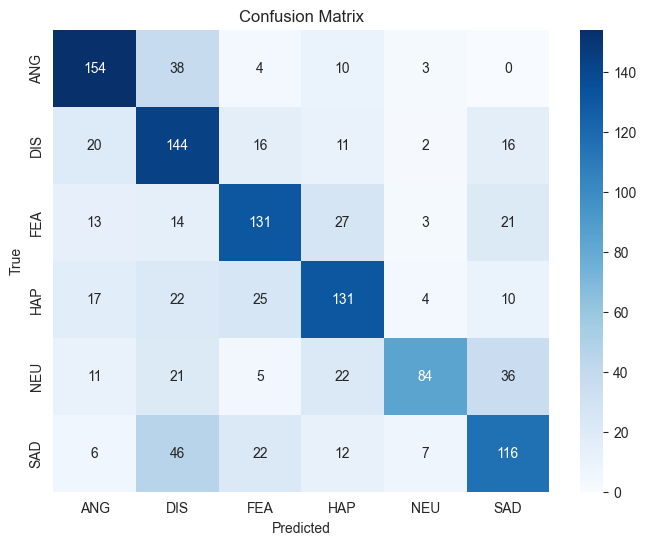

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[k for k, v in sorted(EMO_MAP.items(), key=lambda x: x[1])],
    yticklabels=[k for k, v in sorted(EMO_MAP.items(), key=lambda x: x[1])]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


The confusion matrix reveals that the majority of misclassifications occur between acoustically similar emotional states, particularly among negative emotions and between neutral and low-arousal emotional speech. While emotions with strong prosodic cues such as anger and happiness are recognized reliably, neutral speech remains challenging due to its lack of distinctive acoustic markers. These structured error patterns are consistent with known limitations of speech-only emotion recognition systems.

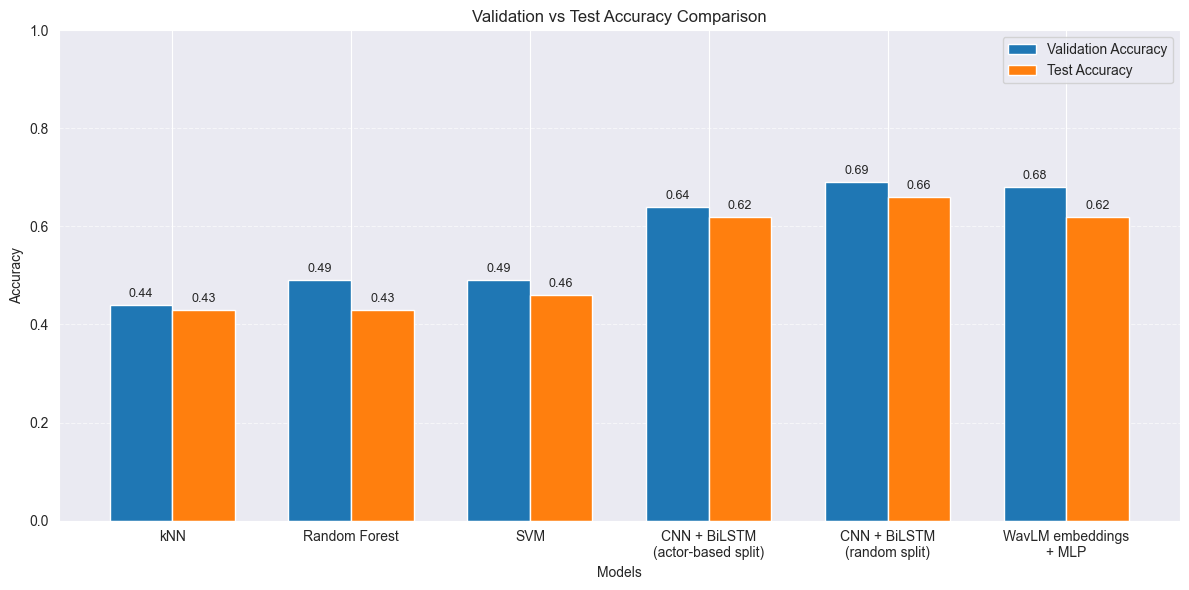

In [26]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    'kNN',
    'Random Forest',
    'SVM',
    'CNN + BiLSTM\n(actor-based split)',
    'CNN + BiLSTM\n(random split)',
    'WavLM embeddings\n+ MLP'
]

val_accuracy = [0.44, 0.49, 0.49, 0.64, 0.69, 0.68]
test_accuracy = [0.43, 0.43, 0.46, 0.62, 0.66, 0.62]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12, 6))

bars_val = plt.bar(x - width/2, val_accuracy, width, label='Validation Accuracy')
bars_test = plt.bar(x + width/2, test_accuracy, width, label='Test Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Validation vs Test Accuracy Comparison')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bars in [bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()
